In [33]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
import math
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.linear_model import LinearRegression

In [4]:
data_dir_root = os.path.join('./data', 'ThingsEEG-Text')
sbj = 'sub-10'
image_model = 'pytorch/cornet_s'
text_model = 'CLIPText'
roi = '17channels'
brain_dir = os.path.join(data_dir_root, 'brain_feature', roi, sbj)
image_dir_seen = os.path.join(data_dir_root, 'visual_feature/ThingsTrain', image_model, sbj)
image_dir_unseen = os.path.join(data_dir_root, 'visual_feature/ThingsTest', image_model, sbj)
text_dir_seen = os.path.join(data_dir_root, 'textual_feature/ThingsTrain/text', text_model, sbj)
text_dir_unseen = os.path.join(data_dir_root, 'textual_feature/ThingsTest/text', text_model, sbj)

# TODO: this is already doing some feature scaling it seems
brain_seen = sio.loadmat(os.path.join(brain_dir, 'eeg_train_data_within.mat'))['data'].astype('double') * 2.0
brain_seen = brain_seen[:,:,27:60] # 70ms-400ms
brain_seen = np.reshape(brain_seen, (brain_seen.shape[0], -1))
image_seen = sio.loadmat(os.path.join(image_dir_seen, 'feat_pca_train.mat'))['data'].astype('double')*50.0
text_seen = sio.loadmat(os.path.join(text_dir_seen, 'text_feat_train.mat'))['data'].astype('double')*2.0
label_seen = sio.loadmat(os.path.join(brain_dir, 'eeg_train_data_within.mat'))['class_idx'].T.astype('int')
image_seen = image_seen[:,0:100]

brain_unseen = sio.loadmat(os.path.join(brain_dir, 'eeg_test_data.mat'))['data'].astype('double')*2.0
brain_unseen = brain_unseen[:, :, 27:60]
brain_unseen = np.reshape(brain_unseen, (brain_unseen.shape[0], -1))
image_unseen = sio.loadmat(os.path.join(image_dir_unseen, 'feat_pca_test.mat'))['data'].astype('double')*50.0
text_unseen = sio.loadmat(os.path.join(text_dir_unseen, 'text_feat_test.mat'))['data'].astype('double')*2.0
label_unseen = sio.loadmat(os.path.join(brain_dir, 'eeg_test_data.mat'))['class_idx'].T.astype('int')
image_unseen = image_unseen[:, 0:100]

In [5]:
# TODO: proper credit
# https://medium.com/@koushikkushal95/logistic-regression-from-scratch-dfb8527a4226
# https://stackoverflow.com/questions/67513075/what-is-c-parameter-in-sklearn-logistic-regression
class CustomLogisticRegression:
    def __init__(self, learning_rate : float = 0.1, threshold : float = 0.5, regularization_strength : float = 1.0):
        self.epsilon = 1e-9
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.weights = None
        self.bias = 0.0
        self.regularization_strength = 1.0 / regularization_strength if regularization_strength != 0.0 else 0.0
    
    def predict_probability(self, x : np.ndarray) -> np.ndarray:
        x_dot_weights = np.dot(x, self.weights) + self.bias
        probabilities = self._sigmoid(x_dot_weights)

        return probabilities

    def predict(self, x : np.ndarray) -> np.ndarray:
        prediction = self.predict_probability(x)
        return np.where(prediction > self.threshold, 1, 0)

    # Returns losses and log likelihoods
    def fit(self, x_train, y_train, epochs=100) -> tuple[np.ndarray, np.ndarray]:
        # Weights on each feature
        self.weights = np.zeros(x_train.shape[1])
        self.bias = 0.0
        
        losses = np.zeros((epochs,))
        log_likelihood = np.zeros((epochs,))

        # Gradient Descent
        for i in range(epochs):
            prediction = self.predict_probability(x_train)
            losses[i] = self._cross_entropy_loss(y_train, prediction)
            log_likelihood[i] = self._log_likelihood(x_train, y_train)
            error_weights, error_bias = self._compute_gradients(x_train, y_train, prediction)
            self._update_parameters(error_weights, error_bias)

        return losses, log_likelihood

    @staticmethod
    def _sigmoid(x : np.ndarray) -> np.ndarray:
        return 1.0 / (1.0 + np.exp(-x))
    
    def _cross_entropy_loss(self, y_true : np.ndarray, y_pred : np.ndarray) -> float:
        # Binary cross entropy loss
        y_zero_loss = y_true * np.log(y_pred + self.epsilon)
        y_one_loss = (1.0 - y_true) * np.log(1.0 - y_pred + self.epsilon)

        return -np.mean(y_zero_loss + y_one_loss)

    def _log_likelihood(self, x : np.ndarray, y : np.ndarray) -> float:
        penalty = self.regularization_strength * np.sum(self.weights ** 2.0)
        scores = np.dot(x, self.weights) + self.bias

        return np.sum((y - 1.0) * scores - np.log(1.0 + np.exp(-scores))) - penalty

    def _compute_gradients(self, x : np.ndarray, y_true : np.ndarray, y_pred : np.ndarray) -> tuple[np.ndarray, float]:
        diff = y_pred - y_true
        penalty = 2.0 * self.regularization_strength * self.weights

        gradients_weights = (1.0 / x.shape[0]) * (np.dot(x.T, diff)) - penalty
        gradient_bias = (1.0 / x.shape[0]) * np.sum(diff)

        return gradients_weights, gradient_bias

    def _update_parameters(self, error_weights : np.ndarray, error_bias : float) -> None:
        self.weights -= self.learning_rate * error_weights
        self.bias -= self.learning_rate * error_bias

In [6]:
# OvR and OvO classifiers

# Process the data such that one class is highlighted in each instance of the data
#   get the resulting output vector, pick maximum probability
class OneVsRest:
    def __init__(self, model_constructor, num_classes : int, use_probability : bool = True):
        self.models = [model_constructor() for _ in range(num_classes)]
        self.num_classes = num_classes
        self.use_probability = use_probability

    def fit(self, x_train : np.ndarray, y_train : np.ndarray, epochs : int = 100) -> tuple[np.ndarray, np.ndarray]:
        total_loss = np.zeros((len(self.models), epochs))
        total_log_likelihood = np.zeros((len(self.models), epochs))

        for class_number, model in enumerate(self.models):
            # Get the binary version of the data
            #   label the current class as positive, and all other classes
            #   as negative
            y_ovr = np.where(y_train == class_number, 1.0, 0.0)
            loss, log_likelihood = model.fit(x_train, y_ovr, epochs=epochs)

            total_loss[class_number, :] += loss
            total_log_likelihood[class_number, :] += log_likelihood

        return total_loss.mean(axis=0), total_log_likelihood.mean(axis=0)

    def predict(self, x : np.ndarray) -> np.ndarray:
        # Get a prediction from every model
        #   each prediction is a probability from 0-1 for each instance
        #       (or just the predicted class if we're not using probability)
        #   arrange these into a matrix
        #   get the argmax from every column of the matrix
        #   consider that to be the class
        matrix = np.zeros((x.shape[0], self.num_classes))

        for class_number, model in enumerate(self.models):
            votes = model.predict_probability(x) if self.use_probability else model.predict(x)
            matrix[:, class_number] = votes

        predicted_classes = np.argmax(matrix, axis=1)
        
        return predicted_classes

class OneVsOne:
    def __init__(self, model_constructor, num_classes : int, use_probability : bool = True):
        self.num_classes = num_classes
        self.models = [model_constructor() for _ in range((num_classes * (num_classes - 1)) // 2)]
        self.use_probability = use_probability

    def fit(self, x_train : np.ndarray, y_train : np.ndarray, epochs : int = 100) -> tuple[np.ndarray, np.ndarray]:
        idx = 0

        total_loss = np.zeros((len(self.models), epochs))
        total_log_likelihood = np.zeros((len(self.models), epochs))

        for class_pos in range(self.num_classes):
            for class_neg in range(class_pos + 1, self.num_classes):
                model = self.models[idx]

                # Filter out classes not in one of the classes
                class_mask = ((y_train == class_pos) | (y_train == class_neg))

                x_ovo = x_train[class_mask]
                # Mark positive class as 1, negative class as 0
                y_ovo = np.where(y_train[class_mask] == class_pos, 1.0, 0.0)

                # Train
                loss, log_likelihood = model.fit(x_ovo, y_ovo, epochs=epochs)

                total_loss[idx, :] += loss
                total_log_likelihood[idx, :] += log_likelihood

                idx += 1

        return total_loss.mean(axis=0), total_log_likelihood.mean(axis=0)

    def predict(self, x : np.ndarray) -> np.ndarray:
        # Each model votes on one class
        #   class with most votes is selected
        #   note very similar to OvR,
        #       but each model votes on only the positive/negative instances
        #       instead of all instances
        idx = 0

        votes_matrix = np.zeros((x.shape[0], self.num_classes))

        for class_pos in range(self.num_classes):
            for class_neg in range(class_pos + 1, self.num_classes):
                model = self.models[idx]

                # On each instance, determine if it was positive/negative
                #   vote for that class
                votes = model.predict_probability(x) if self.use_probability else model.predict(x)

                votes_matrix[:, class_pos] += votes
                votes_matrix[:, class_neg] += 1.0 - votes

                idx += 1

        return np.argmax(votes_matrix, axis=1)

In [7]:
# Various train/test splits
SAMPLES_PER_CLASS = 10

# Only sampling from seen data
def train_test_split(num_classes : int = 50, split_percentage : float = 0.7, random_state=0):
    split_index = math.ceil(SAMPLES_PER_CLASS * split_percentage)

    # All instances where the seen class is within the classes we want
    seen_classes_filter = np.squeeze(label_seen <= num_classes)
    # unseen_classes_filter = np.squeeze(label_unseen <= num_classes)

    # Filter modalities to get only instances with the allowed classes
    brain_seen_reduced = brain_seen[seen_classes_filter]
    image_seen_reduced = image_seen[seen_classes_filter]
    text_seen_reduced = text_seen[seen_classes_filter]
    label_seen_reduced = label_seen[seen_classes_filter]

    # brain_unseen_reduced = brain_unseen[unseen_classes_filter]
    # image_unseen_reduced = image_unseen[unseen_classes_filter]
    # text_unseen_reduced = text_unseen[unseen_classes_filter]
    # label_unseen_reduced = label_unseen[unseen_classes_filter]

    brain_features = brain_seen.shape[1]
    image_features = image_seen.shape[1]
    text_features = text_seen.shape[1]

    # Per class number of training/test examples
    num_training = split_index
    num_test = SAMPLES_PER_CLASS - split_index

    def split_data(seen_instances : np.ndarray, num_features : int) -> tuple[np.ndarray, np.ndarray]:
        train_out = np.zeros((num_training * num_classes, num_features))
        test_out = np.zeros((num_test * num_classes, num_features))

        np.random.seed(random_state)
        train_mask = np.zeros((SAMPLES_PER_CLASS,), dtype=np.bool)
        train_mask[:split_index] = 1
        np.random.shuffle(train_mask)  # Note, in place shuffle

        for i in range(num_classes):
            curr = seen_instances[i * SAMPLES_PER_CLASS:(i + 1) * SAMPLES_PER_CLASS, :]

            train_data = curr[train_mask]
            test_data = curr[~train_mask]

            train_out[i * num_training:(i + 1) * num_training, :] = train_data
            test_out[i * num_test:(i + 1) * num_test, :] = test_data

        return train_out, test_out

    brain_train, brain_test = split_data(brain_seen_reduced, brain_features)
    image_train, image_test = split_data(image_seen_reduced, image_features)
    text_train, text_test = split_data(text_seen_reduced, text_features)
    label_train, label_test = split_data(label_seen_reduced, 1)

    # 0-indexing is more convenient for OvR/OvO
    #   also ensure label dimensions are 1d array
    label_train = label_train.squeeze() - 1
    label_test = label_test.squeeze() - 1

    return pd.DataFrame({
        "Modality": ["Brain", "Image", "Text", "Label"],
        "Train": [brain_train, image_train, text_train, label_train],
        "Test": [brain_test, image_test, text_test, label_test]
    })

train_test_split()

def get_data_from_train_test(dataframe : pd.DataFrame, modality : str, type : str):
    modality_index = dataframe.index[dataframe["Modality"]==modality]
    return dataframe.loc[modality_index, type].item()

In [8]:
# Feature scaling
def normal_scale_features(x : np.ndarray) -> np.ndarray:
    out = np.zeros(x.shape)

    for feature in range(x.shape[1]):
        feature_vector = x[:, feature]

        std = feature_vector.std()
        mean = feature_vector.mean()

        out[:, feature] = (feature_vector - mean) / std

    return out

In [9]:
# Filter instances with too many outliers in them
# Returns truth series, where False represents an outlier
#   any row contains more than 10% outliers, discard it, represents a bad instance
def outlier_mask(x : np.ndarray, tolerance : float = 0.1) -> np.ndarray:
    out = np.zeros(x.shape)

    for feature in range(x.shape[1]):
        feature_vector = x[:, feature]
        # Calculate IQR
        lb = np.quantile(feature_vector.squeeze(), 0.25).item()
        ub = np.quantile(feature_vector.squeeze(), 0.75).item()
        iqr = ub - lb
        whisker_length = 1.5  # in reference to the histogram whisker length

        out[:, feature] = ~((feature_vector < (lb - whisker_length * iqr)) | (feature_vector > (ub + whisker_length * iqr)))

    instance_filter = np.zeros(x.shape[0])

    for instance in range(x.shape[0]):
        instance_filter[instance] = out[instance, :].mean() > (1.0 - tolerance)

    return instance_filter.astype(np.bool)
# TODO: strip noisy features?

In [10]:
# Generate all combinations of modalities
BRAIN_BIT = 1
TEXT_BIT = 2
IMAGE_BIT = 3

all_modalities = pd.DataFrame({
    "Combination": ["Brain", "Text", "Image", "BrainText", "BrainImage", "TextImage", "All"],
    "Bitmap": [BRAIN_BIT, TEXT_BIT, IMAGE_BIT, BRAIN_BIT | TEXT_BIT, BRAIN_BIT | IMAGE_BIT, TEXT_BIT | IMAGE_BIT, BRAIN_BIT | TEXT_BIT | IMAGE_BIT]
})

def get_combined_data(brain_data : np.ndarray, text_data : np.ndarray, image_data : np.ndarray, bitmap : int) -> np.ndarray:
    modalities_data = []

    if bitmap & BRAIN_BIT:
        modalities_data.append(brain_data)
    if bitmap & TEXT_BIT:
        modalities_data.append(text_data)
    if bitmap & IMAGE_BIT:
        modalities_data.append(image_data)

    return np.hstack(tuple(modalities_data))

In [11]:
# Create some baseline parameters for future testing of other features
from sklearn.linear_model import LogisticRegression  # Baseline sklearn model

# Create a baseline train/test split, and extract training dataset and testing dataset
BASELINE_NUM_CLASSES = 50
BASELINE_TRAIN_TEST_SPLIT = 0.7

BASELINE_SPLIT_DATA = train_test_split(BASELINE_NUM_CLASSES, BASELINE_TRAIN_TEST_SPLIT)

baseline_data_train = get_data_from_train_test(BASELINE_SPLIT_DATA, "Brain", "Train")
baseline_data_test = get_data_from_train_test(BASELINE_SPLIT_DATA, "Brain", "Test")
BASELINE_LABEL_TRAIN = get_data_from_train_test(BASELINE_SPLIT_DATA, "Label", "Train")
BASELINE_LABEL_TEST = get_data_from_train_test(BASELINE_SPLIT_DATA, "Label", "Test")

# Perform standard scaling on data
BASELINE_DATA_TRAIN = normal_scale_features(baseline_data_train)
BASELINE_DATA_TEST = normal_scale_features(baseline_data_test)

# Standard hyperparameters
BASELINE_LEARNING_RATE = 0.01
BASELINE_THRESHOLD = 0.5
BASELINE_REGULARIZATION = 1.0
BASELINE_EPOCHS = 100
BASELINE_CUSTOM_MODEL = lambda: CustomLogisticRegression(BASELINE_LEARNING_RATE, BASELINE_THRESHOLD, BASELINE_REGULARIZATION)
BASELINE_USE_PROBABILITY = True
BASELINE_MUTLICLASS = OneVsRest(BASELINE_CUSTOM_MODEL, BASELINE_NUM_CLASSES, BASELINE_USE_PROBABILITY)
BASELINE_SKLEARN_MODEL = LogisticRegression(penalty="l2", multi_class="ovr", C=1.0, max_iter=100, random_state=0)

In [19]:
def basic_stats(y_true : np.ndarray, y_predicted : np.ndarray) -> tuple[float, float, float, float]:
    accuracy = accuracy_score(y_true, y_predicted)
    stats = precision_recall_fscore_support(y_true, y_predicted, average="weighted", zero_division=0.0)

    # Return the various useful stats
    return accuracy, stats[0], stats[1], stats[2]

def compare_stats(var_name : str, var : list, stats : list, do_line_plot : bool = True) -> None:
    df = pd.DataFrame({
        var_name: var,
        "Accuracy": [stat[0] for stat in stats],
        "Precision": [stat[1] for stat in stats],
        "Recall": [stat[2] for stat in stats],
        "F1-Score": [stat[3] for stat in stats]
    })

    long_df = df.melt(var_name, var_name="ScoreType", value_name="Score")

    fig, ax = plt.subplots()

    sns.barplot(long_df, x=var_name, y="Score", hue="ScoreType", ax=ax)
    if do_line_plot:
        ax2 = ax.twinx()
        sns.lineplot(long_df, x=var_name, y="Score", hue="ScoreType", ax=ax2)
    plt.show()

def compare_loss_graph(var_name : str, var : list[str], losses : list) -> None:
    vars = []
    epochs = []
    loss = []

    for i, loss_list in enumerate(losses):
        current_var_name = var[i]

        for epoch, value in enumerate(loss_list):
            epochs.append(epoch)
            loss.append(value)
            vars.append(current_var_name)
    
    df = pd.DataFrame({
        var_name: vars,
        "Epoch": epochs,
        "Loss": loss
    })

    sns.lineplot(df, x="Epoch", y="Loss", hue=var_name)
    plt.show()

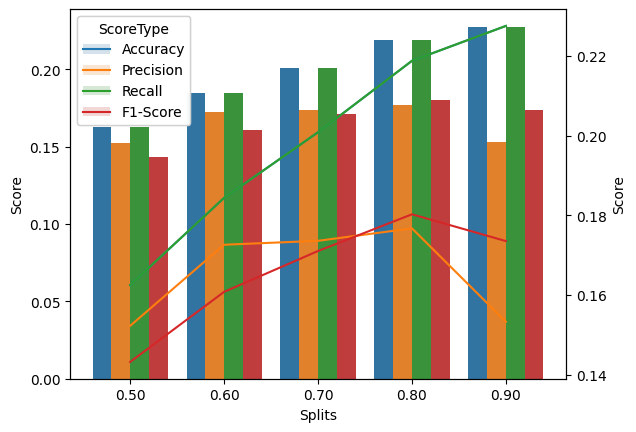

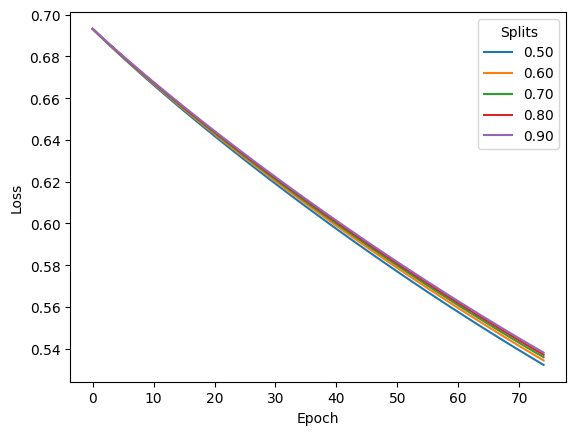

In [ ]:
# Test 1.
#   vary train test splits
#   let's try to find the optimal train-test split for this data
#   k-folds cross validation being used
#       we're using random state to generate a (probably) different train-test split each time
NUM_FOLDS = 8
SPLIT_START = 0.5 # Start with a half-half split, 5 testing, 5 training
SPLIT_END = 0.9 # End with a 9 testing, 1 training split
SPLIT_INC = 0.1
EPOCHS = 100

split_percentage = SPLIT_START

splits = []
losses = []
stats = []

while split_percentage <= SPLIT_END:
    total_loss = np.zeros((EPOCHS,))
    total_accuracy = []
    total_precision = []
    total_recall = []
    total_f1_score = []

    for fold in range(NUM_FOLDS):
        # Use the fold as the random seed
        split_data = train_test_split(BASELINE_NUM_CLASSES, split_percentage, fold)
        
        # Extract the data
        data_train = get_data_from_train_test(split_data, "Brain", "Train")
        data_test = get_data_from_train_test(split_data, "Brain", "Test")
        label_train = get_data_from_train_test(split_data, "Label", "Train")
        label_test = get_data_from_train_test(split_data, "Label", "Test")

        data_train = normal_scale_features(data_train)
        data_test = normal_scale_features(data_test)

        # Train the baseline model
        ovr = BASELINE_MUTLICLASS
        loss, log_likelihood = ovr.fit(data_train, label_train, epochs=EPOCHS)
        predicted = ovr.predict(data_test)

        accuracy, precision, recall, f1score = basic_stats(label_test, predicted)

        total_loss += loss
        total_accuracy.append(accuracy)
        total_precision.append(precision)
        total_recall.append(recall)
        total_f1_score.append(f1score)

    average_loss = total_loss / NUM_FOLDS
    accuracy = np.array(total_accuracy).mean()
    precision = np.array(total_precision).mean()
    recall = np.array(total_recall).mean()
    f1score = np.array(total_f1_score).mean()

    losses.append(average_loss)
    stats.append([accuracy, precision, recall, f1score])
    splits.append(split_percentage)

    split_percentage += SPLIT_INC

# Compare split stats
compare_stats("Splits", [f"{split:.2f}" for split in splits], stats)
# Compare loss curves for each
compare_loss_graph("Splits", [f"{split:.2f}" for split in splits], losses)
# Observations:
#   test/train split has no significant effect on loss graph
#   clearly increasing recall, as we get more examples on training data
#   clearly decreasing precision, as we seem to overfit more, and more
#   f1-score seems relatively consistent across splits (past split 0.5), likely best to use
#       the split 0.7, as overfitting seems to be a clear problem with
#       higher splits (recall becomes disproportionately higher than precision as training examples increase)
# Conclusion:
#   train-test split of 0.7 seems most optimal


Trained models: 1/192
Trained models: 2/192
Trained models: 3/192
Trained models: 4/192
Trained models: 5/192
Trained models: 6/192
Trained models: 7/192
Trained models: 8/192
Trained models: 9/192
Trained models: 10/192
Trained models: 11/192
Trained models: 12/192
Trained models: 13/192
Trained models: 14/192
Trained models: 15/192
Trained models: 16/192
Trained models: 17/192
Trained models: 18/192
Trained models: 19/192
Trained models: 20/192
Trained models: 21/192
Trained models: 22/192
Trained models: 23/192
Trained models: 24/192
Trained models: 25/192
Trained models: 26/192
Trained models: 27/192
Trained models: 28/192
Trained models: 29/192
Trained models: 30/192
Trained models: 31/192
Trained models: 32/192
Trained models: 33/192
Trained models: 34/192
Trained models: 35/192
Trained models: 36/192
Trained models: 37/192
Trained models: 38/192
Trained models: 39/192
Trained models: 40/192
Trained models: 41/192
Trained models: 42/192
Trained models: 43/192
Trained models: 44/1

/tmp/ipykernel_442293/2674952592.py:44: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


Trained models: 66/192
Trained models: 67/192
Trained models: 68/192
Trained models: 69/192


/tmp/ipykernel_442293/2674952592.py:57: RuntimeWarning: overflow encountered in exp
  return np.sum((y - 1.0) * scores - np.log(1.0 + np.exp(-scores))) - penalty


Trained models: 70/192
Trained models: 71/192
Trained models: 72/192
Trained models: 73/192
Trained models: 74/192
Trained models: 75/192
Trained models: 76/192
Trained models: 77/192
Trained models: 78/192
Trained models: 79/192
Trained models: 80/192
Trained models: 81/192
Trained models: 82/192
Trained models: 83/192
Trained models: 84/192
Trained models: 85/192
Trained models: 86/192
Trained models: 87/192
Trained models: 88/192
Trained models: 89/192
Trained models: 90/192
Trained models: 91/192
Trained models: 92/192
Trained models: 93/192
Trained models: 94/192
Trained models: 95/192
Trained models: 96/192
Trained models: 97/192
Trained models: 98/192
Trained models: 99/192
Trained models: 100/192
Trained models: 101/192
Trained models: 102/192
Trained models: 103/192
Trained models: 104/192
Trained models: 105/192
Trained models: 106/192
Trained models: 107/192
Trained models: 108/192
Trained models: 109/192
Trained models: 110/192
Trained models: 111/192
Trained models: 112/19

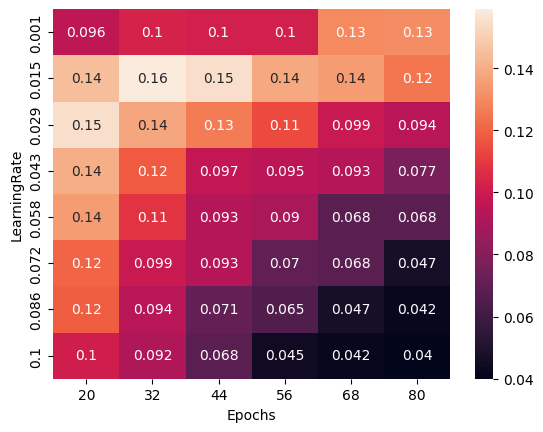

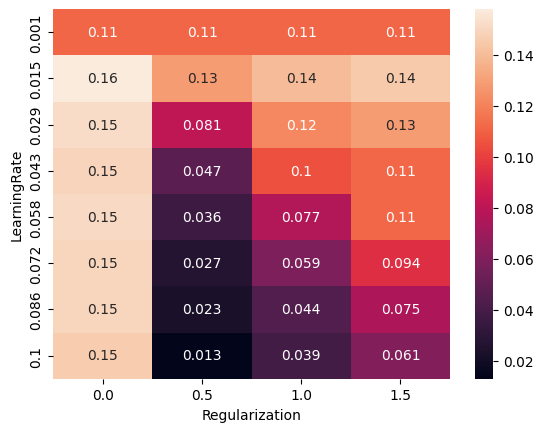

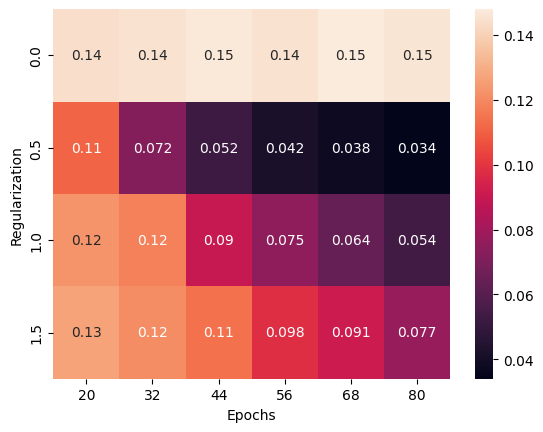

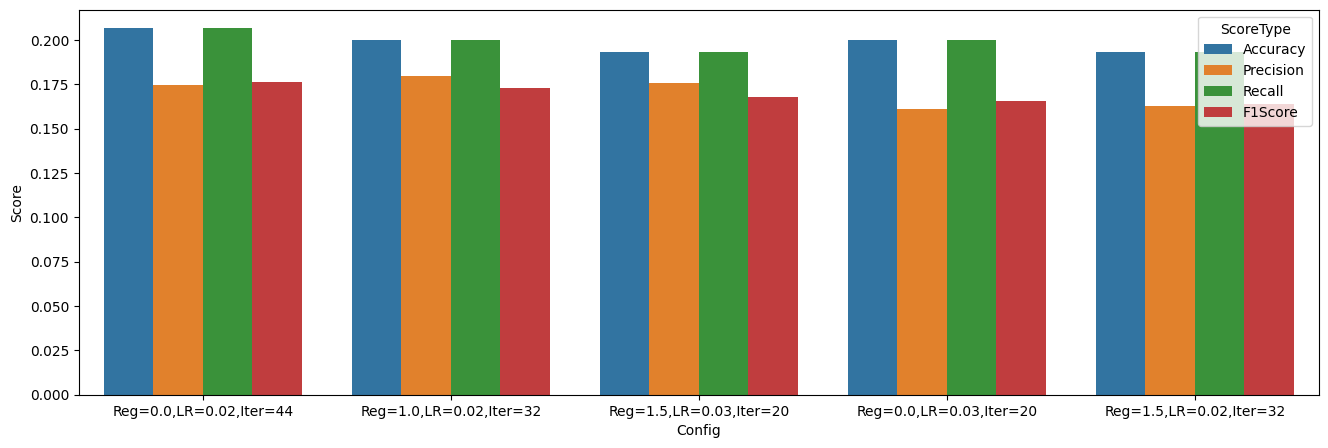

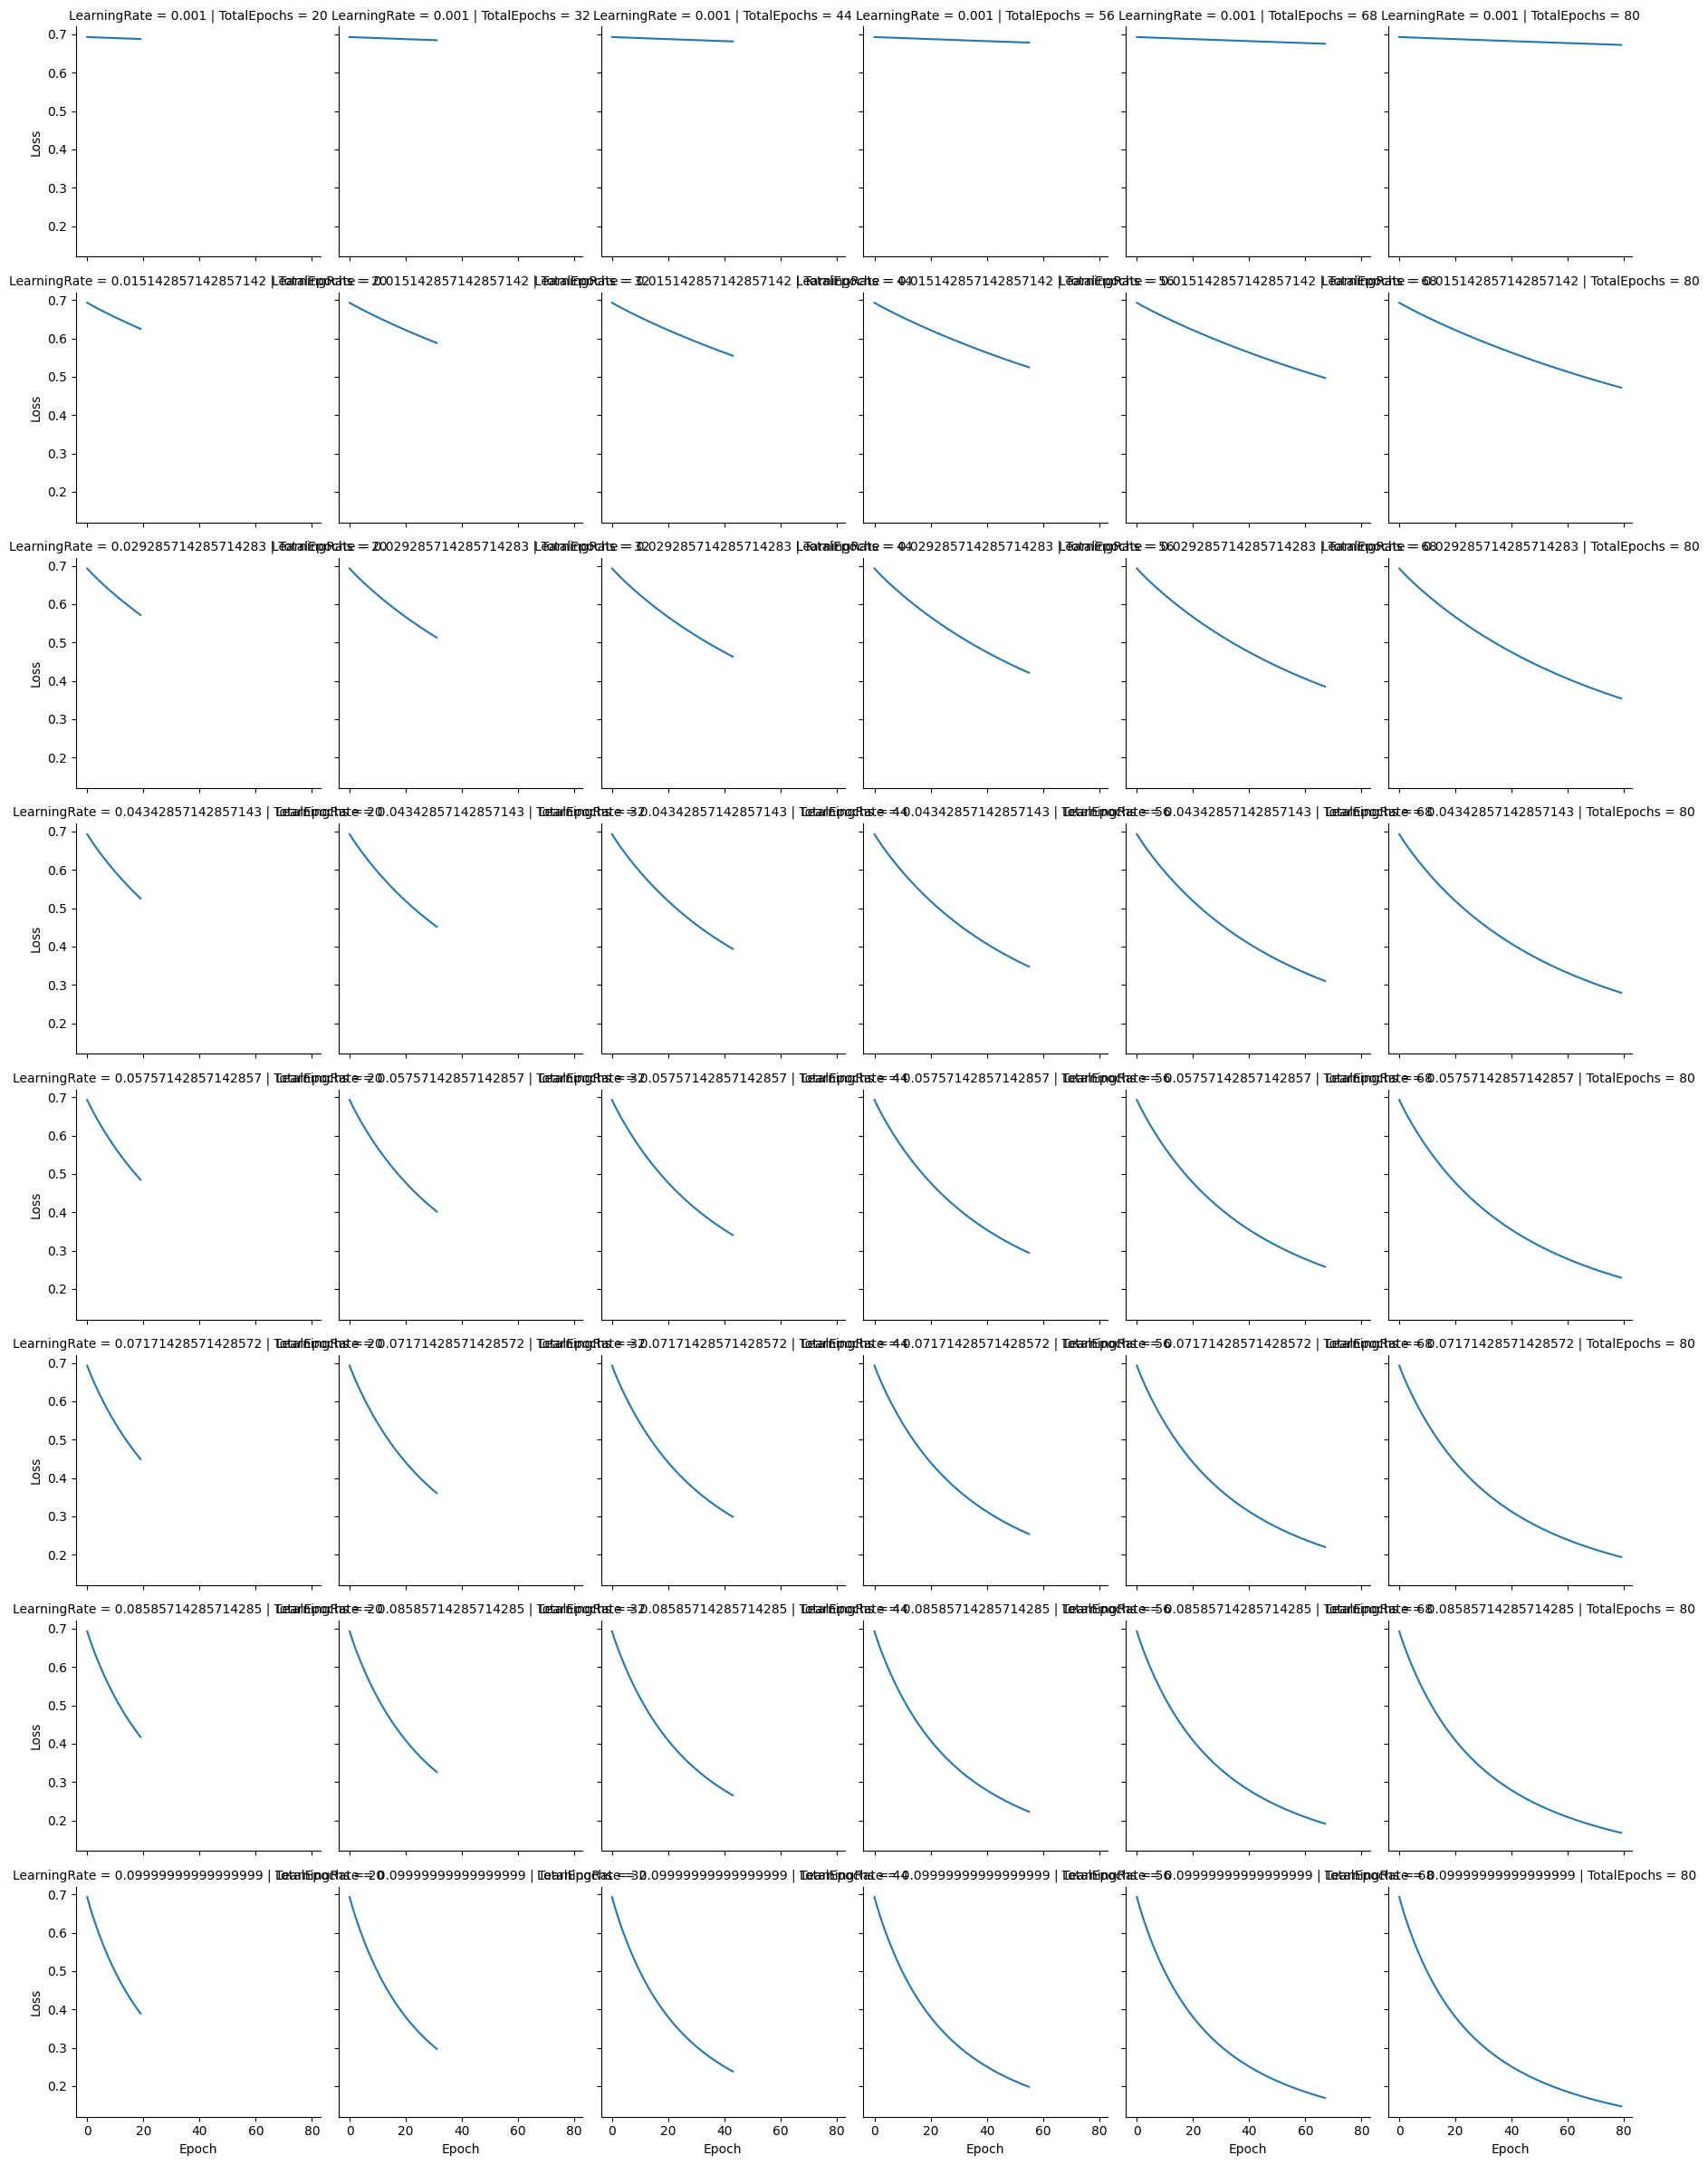

In [ ]:
# TODO: requires k-fold cross validation
# Test 2.
#   hyperparameter grid search
#   - vary regularization parameter
#   - vary learning rate
#   - vary epochs
# Number of cross validation folds
NUM_FOLDS = 4
# Note lower reg param is stronger regularization, but 0.0 is a special case of no regularization
REG_PARAM_START = 0.0  # Start with no regularization
REG_PARAM_NUM_INCREMENTS = 3
REG_PARAM_END = 1.5
REG_PARAM_INCREMENT = (REG_PARAM_END - REG_PARAM_START) / REG_PARAM_NUM_INCREMENTS

LEARN_PARAM_START = 0.001
LEARN_PARAM_NUM_INCREMENTS = 6
LEARN_PARAM_END = 0.1
LEARN_PARAM_INCREMENT = (LEARN_PARAM_END - LEARN_PARAM_START) / LEARN_PARAM_NUM_INCREMENTS

EPOCHS_PARAM_START = 20
EPOCHS_PARAM_NUM_INCREMENTS = 5
EPOCHS_PARAM_END = 80
# TODO: note this might do one extra increment because of floor
EPOCHS_PARAM_INCREMENT = (EPOCHS_PARAM_END - EPOCHS_PARAM_START) // EPOCHS_PARAM_NUM_INCREMENTS

NUM_PERMUTATIONS = (REG_PARAM_NUM_INCREMENTS + 1) * (LEARN_PARAM_NUM_INCREMENTS + 1) * (EPOCHS_PARAM_NUM_INCREMENTS + 1)

TESTING_PROPORTION = 1.0

import threading
import queue
import random

stats = queue.Queue()

trained_models = 0

def test_settings(reg_param : float, learn_param : float, epochs_param : int):
    global TESTING_PROPORTION
    global trained_models
    if random.random() > TESTING_PROPORTION: return

    model = lambda: CustomLogisticRegression(learn_param, 0.5, reg_param)
    ovr = OneVsRest(model, BASELINE_NUM_CLASSES)
    losses, log_likelihood = ovr.fit(BASELINE_DATA_TRAIN, BASELINE_LABEL_TRAIN, epochs=epochs_param)
    predicted = ovr.predict(BASELINE_DATA_TEST)

    trained_models += 1

    print(f"Trained models: {trained_models}/{NUM_PERMUTATIONS}")

    stats.put((reg_param, learn_param, epochs_param, losses, predicted))

processes = []

reg_param = REG_PARAM_START

while reg_param <= REG_PARAM_END:
    learn_param = LEARN_PARAM_START

    while learn_param <= LEARN_PARAM_END:
        epochs_param = EPOCHS_PARAM_START

        while epochs_param <= EPOCHS_PARAM_END:
            #job = threading.Thread(target=test_settings, args=(reg_param, learn_param, epochs_param))
            #processes.append(job)
            #job.start()
            test_settings(reg_param, learn_param, epochs_param)

            epochs_param += EPOCHS_PARAM_INCREMENT
        
        learn_param += LEARN_PARAM_INCREMENT
    
    reg_param += REG_PARAM_INCREMENT

# Wait for all threads to complete
for job in processes:
    job.join()

stat_list = []

while not stats.empty():
    stat_list.append(stats.get())

# Generate statistics for each combination of hyperparameters
generated_stats = []

reg_params = []
learn_params = []
epochs_params = []
accuracy_params = []
precision_params = []
recall_params = []
f1_score_params = []
loss_curves = []

for stat in stat_list:
    reg_param, learn_param, epochs_param, losses, predicted = stat

    accuracy, precision, recall, f1_score = basic_stats(BASELINE_LABEL_TEST, predicted)

    reg_params.append(reg_param)
    learn_params.append(learn_param)
    epochs_params.append(epochs_param)

    accuracy_params.append(accuracy)
    precision_params.append(precision)
    recall_params.append(recall)
    f1_score_params.append(f1_score)

    loss_curves.append(losses)

df = pd.DataFrame({
    "Regularization": reg_params,
    "LearningRate": learn_params,
    "Epochs": epochs_params,
    "Accuracy": accuracy_params,
    "Precision": precision_params,
    "Recall": recall_params,
    "F1Score": f1_score_params,
    "LossCurve": loss_curves
})

long_df = df.melt(("Regularization", "LearningRate", "Epochs"), var_name="ScoreType", value_name="Score")

# print(pivoted.head())
# print(pivoted)

# Display relationships between hyperparameters
# Takes mean of the hyperparameter that isn't being shown, but
#   still should be representative of the relationship between
#   the two hyperparameters and the F1Score
lr_epochs_df = df.pivot_table(index="LearningRate", columns="Epochs", values="F1Score").round(3)
lr_reg_df = df.pivot_table(index="LearningRate", columns="Regularization", values="F1Score").round(3)
reg_epochs_df = df.pivot_table(index="Regularization", columns="Epochs", values="F1Score").round(3)

sns.heatmap(lr_epochs_df, annot=True, xticklabels=lr_epochs_df.columns.values.round(3), yticklabels=lr_epochs_df.index.values.round(3))
plt.show()
# Observations:
#   - clear diagonal pattern, where learning rate must decrease as epochs increase for optimal performance, and vice versa
# Conclusions:
#   - best learning/rate epochs combination likely around 0.015 learning rate, and 30-40 epochs
sns.heatmap(lr_reg_df, annot=True, xticklabels=lr_reg_df.columns.values.round(3), yticklabels=lr_reg_df.index.values.round(3))
plt.show()
# Observations:
#   - no regularization yields consistently high results regardless of learning rate
#       seems we're not overfitting the dataset sufficiently to justify regularization
#   - as learning rate decreases, weaker (higher value) regularization is favoured,
#       possible that lower learning rate leads to underfitting, thus regularization would
#       be counterproductive in such a case
sns.heatmap(reg_epochs_df, annot=True, xticklabels=reg_epochs_df.columns.values.round(3), yticklabels=reg_epochs_df.index.values.round(3))
plt.show()
# Observations:
#   - no regularization yields consistenly high results regardless of epochs
#       (not overfitting, same as before)
#   - weaker regularization is also favoured more as epochs decrease,
#       likely due to the same reason as the relation between regularization and learning rate:
#       we're underfitting the data

# Display performance metrics of "best" hyperparameter combinations
#   NOTE: this should be cross validated, but performance constraints
#   TODO: cross validate this hyperparameter grid search? (lol)
# Filter 5 best combinations based on F1-score
best_combinations_df = df.nlargest(5, "F1Score")

# Combine hyperparameters column into a string
# Need to combine the columns
best_combinations_df["Config"] = best_combinations_df["Regularization"].apply(lambda x: f"Reg={x:.1f},") + \
    best_combinations_df["LearningRate"].apply(lambda x: f"LR={x:.2f},") + \
    best_combinations_df["Epochs"].apply(lambda x: f"Iter={x}")

long_best_df = best_combinations_df.melt(("Config", "Regularization", "LearningRate", "Epochs", "LossCurve"), var_name="ScoreType", value_name="Score")

# Create a bigger axis
fig, ax = plt.subplots(figsize=(16, 5))

sns.barplot(long_best_df, x="Config", y="Score", hue="ScoreType", ax=ax)
plt.show()
# Observations:
#   - low learning rate (0.02-0.03) clearly favoured
#   - low regularization/no regularization (0.0, or high values) clearly favoured
#   - mid-low numer of epochs clearly favoured (range from 20-40 iterations)
# Conclusions:
#   - don't use regularization, have a low learning rate of 0.02-0.03, and run for ~30 epochs

# Create a facet grid for the loss curve given a learning rate and epochs
# We should observe this curve with regularization=0.0, so regularization is disabled
reg_disabled_df = df[df["Regularization"]==0.0]

learning_rates = []
total_epochs = []

epochs = []
loss = []

for index, row in reg_disabled_df.iterrows():
    for epoch, value in enumerate(row["LossCurve"]):
        learning_rates.append(row["LearningRate"])
        total_epochs.append(row["Epochs"])
        epochs.append(epoch)
        loss.append(value)

epoch_learning_rate_df = pd.DataFrame({
    "LearningRate": learning_rates,
    "TotalEpochs": total_epochs,
    "Epoch": epochs,
    "Loss": loss
})

# TODO: loss curve strongly contradicts previous assumptions
#   TODO: k-fold cross validation for verification?
# Plot how the learning rate and total epochs affect the loss curve
g = sns.FacetGrid(epoch_learning_rate_df, row="LearningRate", col="TotalEpochs")
g.map_dataframe(sns.lineplot, x="Epoch", y="Loss")
plt.show()
# Observations:
#   - learning rates of 0.001 clearly too low, no significant change in loss was observed
#   - epochs <40 are clearly too low, even with high learning rates there's still significantly more learning that can be done
#   - high learning rate can somewhat counteract too few epochs


/home/thomas/Coding/ml_model_cw/cw_machine_learning/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


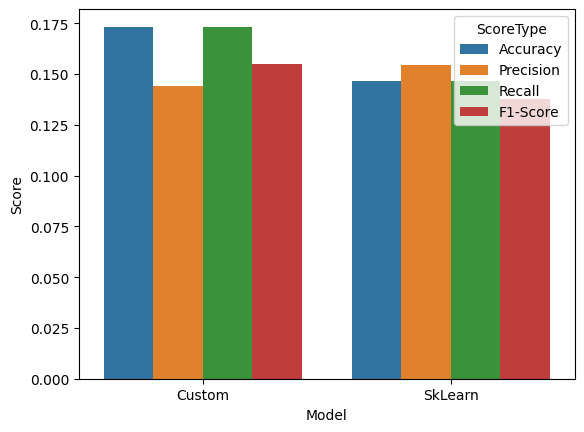

In [44]:
# TODO: using optimal hyperparameters, measure model performance, and compare to sklearn baseline
# Using the optimal hyperparameters, create our own model now (and run on many more classes)
NUM_CLASSES = 50
OPTIMAL_LR = 0.1
OPTIMAL_REGULARIZATION = 0.0  # (disabled)
OPTIMAL_EPOCHS = 60

split_data = train_test_split(NUM_CLASSES, 0.7, random_state=0)
brain_train = get_data_from_train_test(split_data, "Brain", "Train")
brain_test = get_data_from_train_test(split_data, "Brain", "Test")
label_train = get_data_from_train_test(split_data, "Label", "Train")
label_test = get_data_from_train_test(split_data, "Label", "Test")

brain_train = normal_scale_features(brain_train)
brain_test = normal_scale_features(brain_test)

model_constructor = lambda: CustomLogisticRegression(learning_rate=OPTIMAL_LR, regularization_strength=OPTIMAL_REGULARIZATION)
# Note using OvO isn't feasible due to the number of binary linear regressors it would require
#   (it scales with the square of the number of classes)
ovr = OneVsRest(model_constructor, NUM_CLASSES)

ovr.fit(brain_train, label_train, OPTIMAL_EPOCHS)
custom_pred = ovr.predict(brain_test)

sklearn_model = LogisticRegression(multi_class="ovr")
sklearn_model.fit(brain_train, label_train)
sklearn_pred = sklearn_model.predict(brain_test)

# Compare performance metrics of two models
custom_stats = basic_stats(label_test, custom_pred)
sklearn_stats = basic_stats(label_test, sklearn_pred)

compare_stats("Model", ["Custom", "SkLearn"], [
    custom_stats,
    sklearn_stats
], False)
# Observations:
#   - custom model is essentially equivalent to sklearn model in all areas
#   TODO: the reason sklearn performs better on precision
#       is because my penalty is messed up...
#   - sklearn model performs slightly better on precision, either because:
#       - hyperparameter grid search not being cross-validated, and thus
#       picking suboptimal hyperparameters
#       - better solver

# TODO: more metrics to compare upon?


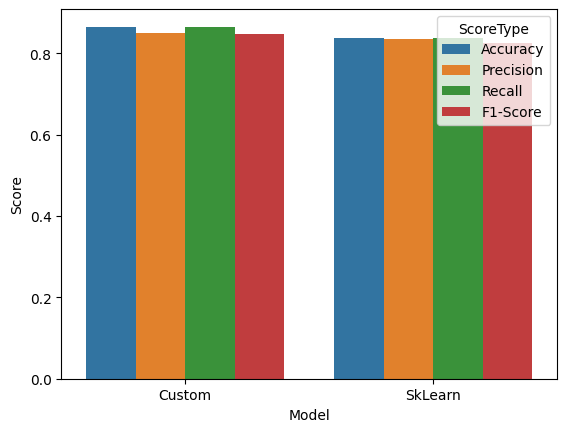

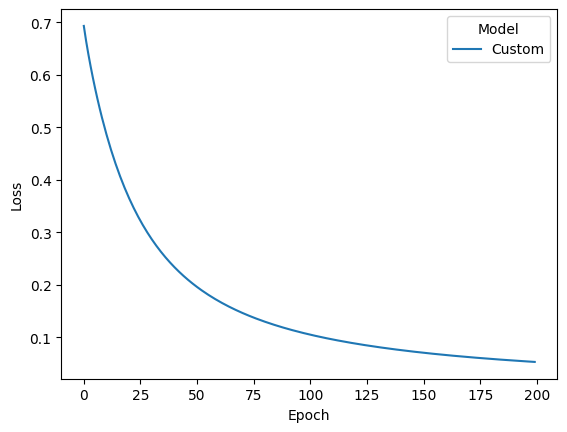

In [ ]:
# From here we'll be adapting the model to a fewshot learning paradigm this is to
#   1. maximise performance despite the small number of samples per class (10 at most, but we need test data as well)
#   2. allow for faster training considering the vast number of classes
#   3. make it easier to collect data considering ideally, fewer samples will be needed for each class

# Train with many more classes (TODO: ideally all)
NUM_CLASSES = 100
few_shot_data = train_test_split(NUM_CLASSES, 0.3)

# Combine all modalities to maximise features to learn from
combined_data_train = get_combined_data(
    get_data_from_train_test(few_shot_data, "Brain", "Train"),
    get_data_from_train_test(few_shot_data, "Text", "Train"),
    get_data_from_train_test(few_shot_data, "Image", "Train"),
    BRAIN_BIT | TEXT_BIT | IMAGE_BIT
)
combined_data_test = get_combined_data(
    get_data_from_train_test(few_shot_data, "Brain", "Test"),
    get_data_from_train_test(few_shot_data, "Text", "Test"),
    get_data_from_train_test(few_shot_data, "Image", "Test"),
    BRAIN_BIT | TEXT_BIT | IMAGE_BIT
)
combined_label_train = get_data_from_train_test(few_shot_data, "Label", "Train")
combined_label_test = get_data_from_train_test(few_shot_data, "Label", "Test")

# TODO: filter outlier instances/features

# Scale features for regularization
combined_data_train = normal_scale_features(combined_data_train)
combined_data_test = normal_scale_features(combined_data_test)

# High learning rate because low number of samples, and use regularization
fewshot_model = lambda: CustomLogisticRegression(learning_rate=0.1, regularization_strength=0.0)
ovr = OneVsRest(fewshot_model, NUM_CLASSES)

# Use a small number of epochs to counteract the number of classes, and high learning rate
losses, log_likelihood = ovr.fit(combined_data_train, combined_label_train, epochs=200)
custom_predicted = ovr.predict(combined_data_test)

# Use SkLearn baseline model
sklearn_model = LogisticRegression()
sklearn_model.fit(combined_data_train, combined_label_train)
sklearn_predicted = sklearn_model.predict(combined_data_test)

# Compare the fewshot learning paradigm to the baseline sklearn model (using combined data, TODO: could make it use worse data to make us look better)
custom_stats = basic_stats(combined_label_test, custom_predicted)
sklearn_stats = basic_stats(combined_label_test, sklearn_predicted)

compare_stats("Model", ["Custom", "SkLearn"], [custom_stats, sklearn_stats], False)
compare_loss_graph("Model", ["Custom"], [losses])

# We'll modify the model in the following ways to enable this paradigm
#   1. include L2 regularization to prevent overfitting
#   2. combine all modalities to increase the number of features per sample, likely
#       allowing the model to better capture the pattern of the data
#   TODO: 3. metric-level FSL? whatever that means, does this allow for unlabelled data to be used for training?

In [ ]:
# TODO: regularization is assuredly broken, algorithm is also fundamentaly wrong likely
# TODO: make sklearn model use only one modality :)
# TODO: implement some few-shot learning paradigm behaviours
#   notably: combined modalities for more data, regularization for overfitting
#   ideally: the combined modalities makes up for the fact we have very few test examples (does)
# TODO: why did we choose logistic regression
# TODO: training/validation procedure
#   why OvR better than OvO? - number of classes makes it impractical for OvO
# TODO: clear explanation of accuracy, precision, recall, f1-score (likely already have, maybe in context of comparison between baseline and custom)
# TODO: use tSNE to analyse dataset in collab
# TODO: plot final test performance across multiple statistics
# TODO: use confusion matrices and precision-recall curves (can we even do this for multiclass? - yes obviously)
# TODO: plot loss/log likelihood throughout training

# TODO: compare between only brain/text/image, and the other combinations of modalities
# TODO: the problem identified in 2.1 is the small number of samples per class, we fixed this with the few-shot learning paradigm

# TODO: few-shot learning uses a similarity function, that learns from the small set of training data
#   this is basically just the same as logistic regression??! or any learning model??!
#   one-way to implement FSL is data-level, incorporate more features through some method (we can do this by combining modalities)
#   regularization is one way to fix FSL, limiting parameter values to prevent overfitting
#   metric-level FSL?
#   https://www.digitalocean.com/community/tutorials/few-shot-learning